In [2]:
import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json

# public client
pub_client = cbpro.PublicClient()

# authentication
f = open('/Users/jonghyunpark/volatility.json','r')
data = json.load(f)

# authenticated client
locals().update(data)

auth_client = cbpro.AuthenticatedClient(API_KEY, API_SECRET, API_PASS)

pd.set_option('display.max_rows',None)

## Volatility breakout strategy

1. Get list of top 5 tickers based on last 24 hr volume in USD
2. Apply breakout strategy
    - Get past day's top X coins to trade
    - Range based on window, rather than just past day
3. Exit out the next day

## Lessons

1. Noise ratio filtering not working well
    - Maybe because it's bull market in the past year
2. Volume 5 day moving average not working well
3. Close price 5 day moving average not working well

In [2]:
# get list of tickers in USD
products = pub_client.get_products()
ticker_list = []
for obj in products:
    if 'USD' in obj['id'] and 'USDT' not in obj['id'] and 'USDC' not in obj['id']:
        ticker_list.append(obj['id'])

In [3]:
# # get volume in USD
# vol_df = pd.DataFrame(columns=['ticker','vol_usd'])
# for ticker in ticker_list:
# #     print(ticker)
#     try:
#         vol_coin = float(pub_client.get_product_24hr_stats(ticker)['volume'])
#         usd_price = float(pub_client.get_product_24hr_stats(ticker)['last'])
#         vol_usd = vol_coin*usd_price
#         vol_df = vol_df.append({'ticker':ticker, 'vol_usd':vol_usd}, ignore_index=True)
#     except:
#         print('Volume keyerror!')

In [4]:
# get 1 day ohlcv
df_hist_dict = {}
min_len = 1e6
for ticker in ticker_list:
    df = pd.DataFrame(pub_client.get_product_historic_rates(ticker, granularity=24*60*60),
                      columns=['time','low','high','open','close','volume']).sort_values('time')
    df['time'] = pd.to_datetime(df['time'],unit='s')
    df.set_index('time', inplace=True)
    df_hist_dict[ticker] = df
    if len(df) < min_len: min_len = len(df)

print(min_len)

4


In [5]:
def get_signal(past_high, past_low, cur_open, cur_high, k=0.5):
    price_range = past_high - past_low
    
    # if current day's price has satisfied the standard, we buy
    if cur_high > cur_open + price_range * k:
        buy_price = cur_open + price_range * k
        return buy_price
    else:
        # no buy signal
        return -1

In [6]:
# volatility breakout strategy
verbose = 1
num_tickers = 5
k = 0.5

transaction_fee = 0.002
slippage = 0.001

def backtest_vb(num_tickers, k, verbose=0):

    # set up initial portfolio df
    df_port = df_hist_dict['BTC-USD'].copy()[['low']]
    df_port.columns = ['total_fund']
    initial_cash = 10000
    df_port['total_fund'] = 0.
    df_port.loc[:,:] = 0.
    df_port.iloc[0] = initial_cash
    
    # coin port df
    df_coin_port = df_port.copy().drop(['total_fund'], axis=1)
    for ticker in ticker_list:
        df_coin_port[ticker] = 0
    df_coin_port.columns = ticker_list
    df_coin_port.loc[:,:] = 0
    
    for i, time in enumerate(df_port.index):
        
        past_time = df_port.index[i-1]
        ppast_time = df_port.index[i-2]
        
        if verbose:
            print('=====================')
            print(f'time: {time}')
            
        if i == 0:
            pass
        else:
            cash_sum = 0
            pnl = 0

            # first, find top X tickers based on volume
#             df_vol = pd.DataFrame(columns=['ticker','vol_usd'])
            df_vol = pd.DataFrame(columns=['ticker','vol_usd'])
            for ticker in ticker_list:
                try:
                    vol_coin = df_hist_dict[ticker].loc[past_time, 'volume']
                    close_price = df_hist_dict[ticker].loc[past_time, 'close']
                    vol_usd = vol_coin*close_price

                    df_vol = df_vol.append({'ticker':ticker, 'vol_usd':vol_coin*close_price}, ignore_index=True)
                except:
                    pass

            # top X coins
            final_list = df_vol.sort_values('vol_usd', ascending=False)\
                                .head(num_tickers)\
                                .ticker.tolist()

            if verbose:
                print(f'Trading coins: {final_list}')
            
            cur_cash = df_port.iloc[i-1].values
            
            # if the list is not empty
            if len(final_list) > 0:
#                 avail_cash = cur_cash/num_tickers  # 1/n cash for each ticker
                avail_cash = cur_cash/10
                cash_left = cur_cash - avail_cash * len(final_list)
                
                for j, ticker in enumerate(final_list):
                    
                    if verbose:
                        print('----------------------')
                        print(f'ticker: {ticker}')

                    past_high = df_hist_dict[ticker].loc[past_time, 'high']
                    past_low = df_hist_dict[ticker].loc[past_time, 'low']
                    past_open = df_hist_dict[ticker].loc[past_time, 'open']
                    past_close = df_hist_dict[ticker].loc[past_time, 'close']
                    cur_open = df_hist_dict[ticker].loc[time, 'open']
                    cur_high = df_hist_dict[ticker].loc[time, 'high']
                    cur_close = df_hist_dict[ticker].loc[time, 'close']
                    
                    buy_price = get_signal(past_high, past_low, cur_open, cur_high, k)

                    if verbose:
                        print(f'buy_price: {buy_price}')
                        print(f'avail_cash: {avail_cash}')

                    # open today's position and close at close price
                    if buy_price > 0:
                        coins_purchased = avail_cash * (1 - transaction_fee - slippage) / buy_price
                        cash_earned = coins_purchased * cur_close * (1 - transaction_fee - slippage)
                        pnl += cash_earned - avail_cash
                        cash_sum += cash_earned
                        
                        if verbose:
                            print(f'current_close: {cur_close}')
                            print(f'cash_earned: {cash_earned}')

                    else:
                        cash_sum += avail_cash
            # empty list
            else:
                cash_left = cur_cash

            # reflect trading result
            df_port.loc[time] = cash_sum + cash_left
            
            if verbose:
                print('!-----------------!')
                print(f'total pnl: {pnl}')
                print(f'port value: {df_port.loc[time].values}')

    return df_port

In [7]:
df_port = backtest_vb(num_tickers=4, k=0.6, verbose=1)

time: 2021-01-26 00:00:00
time: 2021-01-27 00:00:00
Trading coins: ['BTC-USD', 'ETH-USD', 'UNI-USD', 'LINK-USD']
----------------------
ticker: BTC-USD
buy_price: -1
avail_cash: [1000.]
----------------------
ticker: ETH-USD
buy_price: -1
avail_cash: [1000.]
----------------------
ticker: UNI-USD
buy_price: -1
avail_cash: [1000.]
----------------------
ticker: LINK-USD
buy_price: -1
avail_cash: [1000.]
!-----------------!
total pnl: 0
port value: [10000.]
time: 2021-01-28 00:00:00
Trading coins: ['BTC-USD', 'ETH-USD', 'UNI-USD', 'LINK-USD']
----------------------
ticker: BTC-USD
buy_price: 32471.282
avail_cash: [1000.]
current_close: 33488.99
cash_earned: [1025.16301823]
----------------------
ticker: ETH-USD
buy_price: 1342.536
avail_cash: [1000.]
current_close: 1333.19
cash_earned: [987.089254]
----------------------
ticker: UNI-USD
buy_price: -1
avail_cash: [1000.]
----------------------
ticker: LINK-USD
buy_price: 22.794444
avail_cash: [1000.]
current_close: 23.07837
cash_earned: [

<AxesSubplot:xlabel='time'>

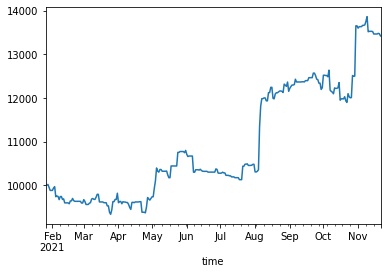

In [8]:
df_port['total_fund'].plot.line()

In [9]:
# evaluate by sharpe ratio and sortino ratio
def eval_port(df, is_bm=False, verbose=0):
    col = 'close' if is_bm else 'total_fund'
    df['daily_return'] = (df - df.shift(1))/df
    daily_return = df['daily_return'].dropna()
    df['past_max'] = df[col].cummax()
    df['dd'] = 1 - df[col]/df['past_max']

    final_return = round((df.iloc[-1,0]-df.iloc[0,0])/df.iloc[0,0] * 100, 1)
    sp_ratio = np.mean(daily_return)/np.std(daily_return) * np.sqrt(365)
    st_ratio = np.mean(daily_return)/np.std(daily_return[daily_return<0]) * np.sqrt(365)
    mdd = round(df['dd'].max()*100, 2)
    win_rate = round(len(df[df['daily_return'] > 0])/len(df[df['daily_return'] != 0])*100, 2)
    trading_freq = round(len(df[df['daily_return'] != 0])/len(df)*100, 2)
    pnl_ratio = abs(round(df[df['daily_return'] > 0].daily_return.mean()/df[df['daily_return'] < 0].daily_return.mean(), 2))

    if verbose:
        print(f'End Return: {final_return}%')
        print(f'Max Drawdown: {mdd}%')
        print(f'Sharpe Ratio: {sp_ratio}')
        print(f'Sortino Ratio: {st_ratio}')
        print(f'Win rate: {win_rate}%')
        print(f'Trading frequency: {trading_freq}%')
        print(f'Profit & Loss ratio: {pnl_ratio}')
    
    return final_return, sp_ratio, st_ratio, mdd, win_rate, trading_freq, pnl_ratio

In [10]:
eval_port(df_port, verbose=1)

End Return: 34.2%
Max Drawdown: 6.84%
Sharpe Ratio: 1.6081332131010435
Sortino Ratio: 2.2237569137269113
Win rate: 51.05%
Trading frequency: 63.33%
Profit & Loss ratio: 1.4


(34.2, 1.6081332131010435, 2.2237569137269113, 6.84, 51.05, 63.33, 1.4)

<AxesSubplot:xlabel='time'>

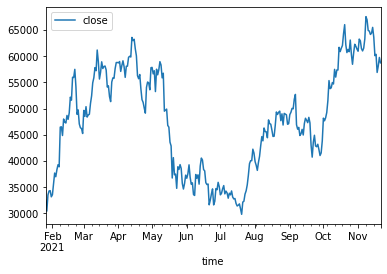

In [11]:
# compare with holding BTC in the same period
df_bm = df_hist_dict['BTC-USD'][['close']]
df_bm.plot()

In [12]:
eval_port(df_bm, is_bm=True, verbose=1)

End Return: 80.6%
Max Drawdown: 53.14%
Sharpe Ratio: 0.4962493713269693
Sortino Ratio: 0.7109662875947751
Win rate: 51.33%
Trading frequency: 100.0%
Profit & Loss ratio: 1.01


/Users/jonghyunpark/opt/miniconda3/envs/radish/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jonghyunpark/opt/miniconda3/envs/radish/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jonghyunpark/opt/miniconda3/envs/radish/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

(80.6, 0.4962493713269693, 0.7109662875947751, 53.14, 51.33, 100.0, 1.01)

In [ ]:
import matplotlib.pyplot as plt

# find best k, window and num_tickers
df_test_res = pd.DataFrame(columns=['num_tickers','k','final_return','sharpe_ratio','sortino_ratio','mdd','win_rate','trading_freq','pnl_ratio'])
for i in [4, 5, 6, 7]:
    for j in [0.5, 0.6, 0.7, 0.8]:
        print('====================')
        print(f'num_tickers: {i}')
        print(f'k = {j}')
        print(f'noise_ratio = {k}')
        df_port = backtest_vb(num_tickers=i, k=j, verbose=0)
        res = eval_port(df_port, verbose=0)
        df_port['total_fund'].plot.line()
        plt.show()
        plt.close()
        df_test_res = df_test_res.append({'num_tickers':i,
                                          'k':j,
                                          'noise_ratio':k,
                                          'final_return': res[0],
                                          'sharpe_ratio':res[1],
                                          'sortino_ratio':res[2],
                                          'mdd':res[3],
                                          'win_rate':res[4],
                                          'trading_freq':res[5],
                                          'pnl_ratio':res[6]}, ignore_index=True)

In [ ]:
df_test_res.sort_values('sortino_ratio', ascending=False).head(10)

# Conclusion

* num_tickers = 4
* k = 0.6